In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import linalg
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from math import comb
import random
import time
from sklearn.metrics import mean_squared_error
import copy
from scipy.ndimage import gaussian_filter1d
import os

import scipy.linalg as lin
from scipy.optimize import basinhopping
from scipy.optimize import differential_evolution
from scipy.optimize import brute

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
import wandb


In [28]:
directory = 'cartpole_constant_middlelayer_5_trials_run2'
#directory = ('cartpole_constant_para_5_trials_run3')
title = f'Mean RMSE over Window Length, {5} Trials, Constant Middle Layer: 128'

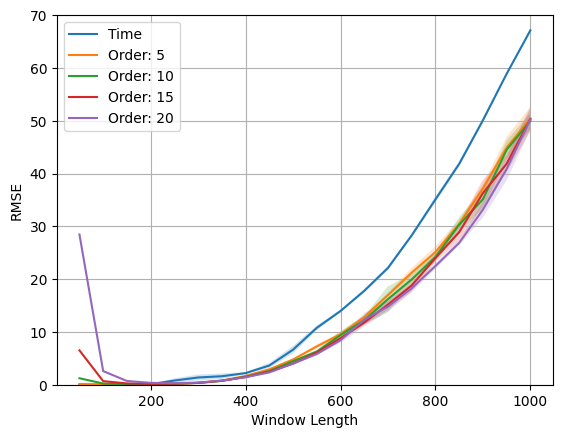

In [16]:
# Load data and do the plotting
#plt.figure(figsize=(12, 6))
num_trials = 5
N = np.loadtxt(f'{directory}/N_data.txt')
leg_order = np.loadtxt(f'{directory}/Leg_data.txt')
data = np.zeros((num_trials,len(leg_order)+1,len(N)))
for trial in range(num_trials):
    RMSE_data_filename = os.path.join(directory, f'RMSE_data_{trial+1}.txt')
    data[trial,:,:] = np.loadtxt(RMSE_data_filename)
data = np.where(data > 200, np.nan, data)

plot_data_mean = np.zeros((len(leg_order)+1,len(N)))
plot_data_std = np.zeros((len(leg_order)+1,len(N)))
for order_n in range(len(leg_order)+1):
    plot_data_mean[order_n,:] = np.nanmean(data[:,order_n,:], axis=0)
    plot_data_std[order_n,:] = np.nanstd(data[:,order_n,:], axis=0)
    if order_n == 0:
        plot_label = 'Time'
    else:
        plot_label = f'Order: {int(leg_order[order_n-1])}'
    plt.plot(N, plot_data_mean[order_n,:], label=plot_label)
    plt.fill_between(N, plot_data_mean[order_n,:] - plot_data_std[order_n,:], plot_data_mean[order_n,:] + plot_data_std[order_n,:], alpha=0.2)
#plt.yscale('log')
plt.ylim([0.0,175])
#plt.title(title)
plt.xlabel('Window Length')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.ylim([0,70])
plt.savefig('NN_sysID_constMid.png')

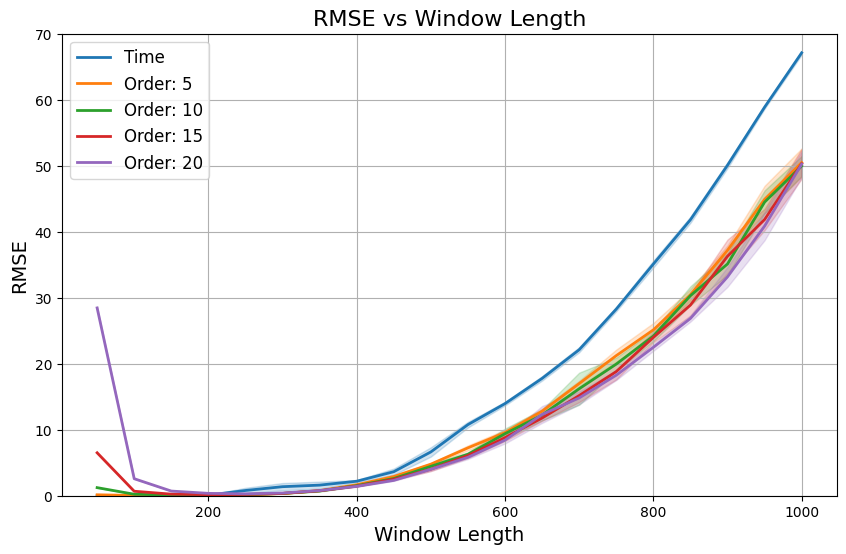

In [18]:
# Load data
num_trials = 5
N = np.loadtxt(f'{directory}/N_data.txt')  # X-axis values
leg_order = np.loadtxt(f'{directory}/Leg_data.txt')  # Legend orders
data = np.zeros((num_trials, len(leg_order) + 1, len(N)))

# Load RMSE data
for trial in range(num_trials):
    RMSE_data_filename = os.path.join(directory, f'RMSE_data_{trial+1}.txt')
    data[trial, :, :] = np.loadtxt(RMSE_data_filename)

# Replace large RMSE values with NaN for cleaner plots
data = np.where(data > 200, np.nan, data)

# Precompute mean and standard deviation
plot_data_mean = np.zeros((len(leg_order) + 1, len(N)))
plot_data_std = np.zeros((len(leg_order) + 1, len(N)))

# Plot data
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # Distinct colors

for order_n in range(len(leg_order) + 1):
    plot_data_mean[order_n, :] = np.nanmean(data[:, order_n, :], axis=0)
    plot_data_std[order_n, :] = np.nanstd(data[:, order_n, :], axis=0)
    
    # Labeling
    if order_n == 0:
        plot_label = 'Time'
    else:
        plot_label = f'Order: {int(leg_order[order_n-1])}'
    
    # Plot mean and fill between standard deviations
    plt.plot(N, plot_data_mean[order_n, :], label=plot_label, color=colors[order_n % len(colors)], linewidth=2)
    plt.fill_between(N, plot_data_mean[order_n, :] - plot_data_std[order_n, :], 
                     plot_data_mean[order_n, :] + plot_data_std[order_n, :], 
                     color=colors[order_n % len(colors)], alpha=0.2)

# Customize plot
plt.xlabel('Window Length', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.ylim([0, 70])  # Adjust y-limits
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.title('RMSE vs Window Length', fontsize=16)

# Save plot
plt.savefig('NN_sysID_constMid.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

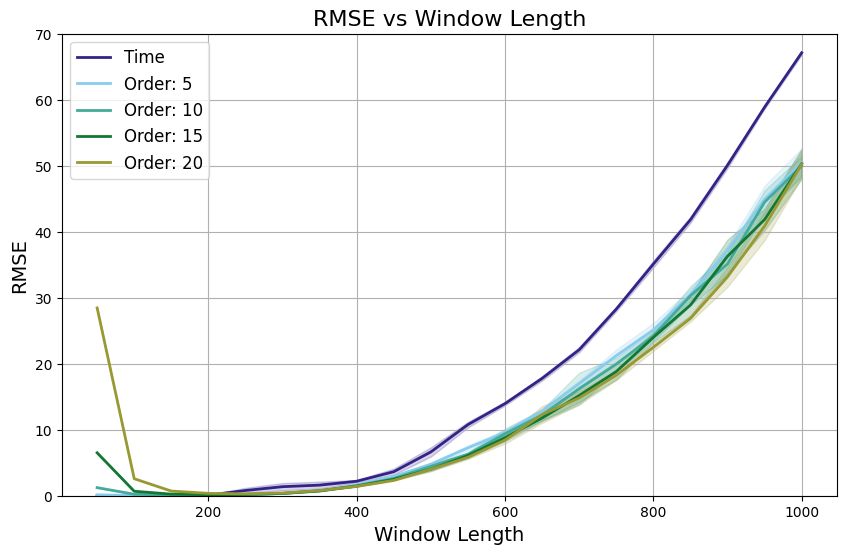

In [19]:
# Load data
num_trials = 5
N = np.loadtxt(f'{directory}/N_data.txt')  # X-axis values
leg_order = np.loadtxt(f'{directory}/Leg_data.txt')  # Legend orders
data = np.zeros((num_trials, len(leg_order) + 1, len(N)))

# Load RMSE data
for trial in range(num_trials):
    RMSE_data_filename = os.path.join(directory, f'RMSE_data_{trial+1}.txt')
    data[trial, :, :] = np.loadtxt(RMSE_data_filename)

# Replace large RMSE values with NaN for cleaner plots
data = np.where(data > 200, np.nan, data)

# Precompute mean and standard deviation
plot_data_mean = np.zeros((len(leg_order) + 1, len(N)))
plot_data_std = np.zeros((len(leg_order) + 1, len(N)))

# Define colorblind-friendly color palette (Tol's palette)
colors = ['#332288', '#88CCEE', '#44AA99', '#117733', '#999933', '#DDCC77', '#CC6677', '#882255', '#AA4499']

# Plot data
plt.figure(figsize=(10, 6))

for order_n in range(len(leg_order) + 1):
    plot_data_mean[order_n, :] = np.nanmean(data[:, order_n, :], axis=0)
    plot_data_std[order_n, :] = np.nanstd(data[:, order_n, :], axis=0)
    
    # Labeling
    if order_n == 0:
        plot_label = 'Time'
    else:
        plot_label = f'Order: {int(leg_order[order_n-1])}'
    
    # Plot mean and fill between standard deviations
    plt.plot(N, plot_data_mean[order_n, :], label=plot_label, color=colors[order_n % len(colors)], linewidth=2)
    plt.fill_between(N, plot_data_mean[order_n, :] - plot_data_std[order_n, :], 
                     plot_data_mean[order_n, :] + plot_data_std[order_n, :], 
                     color=colors[order_n % len(colors)], alpha=0.2)

# Customize plot
plt.xlabel('Window Length', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.ylim([0, 70])  # Adjust y-limits
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.title('RMSE vs Window Length', fontsize=16)

# Save plot
plt.savefig('NN_sysID_constMid.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

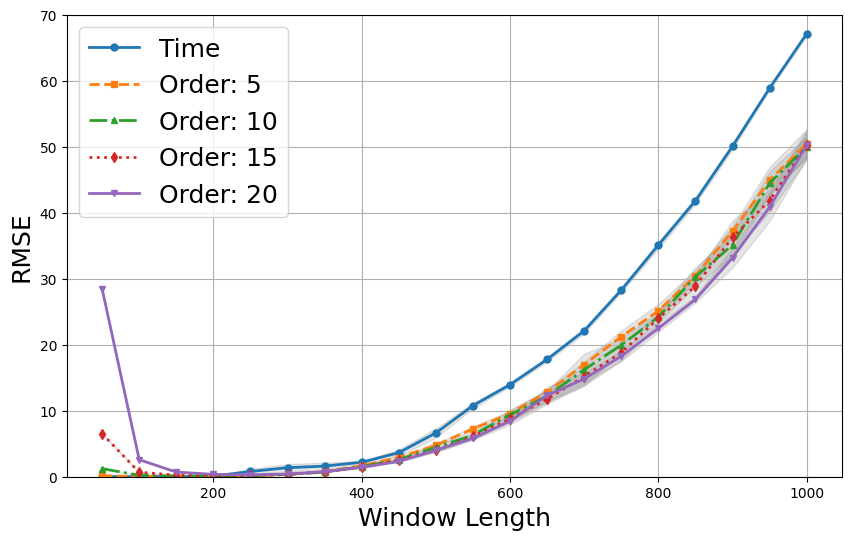

In [29]:
# Load data
num_trials = 5
N = np.loadtxt(f'{directory}/N_data.txt')  # X-axis values
leg_order = np.loadtxt(f'{directory}/Leg_data.txt')  # Legend orders
data = np.zeros((num_trials, len(leg_order) + 1, len(N)))

# Load RMSE data
for trial in range(num_trials):
    RMSE_data_filename = os.path.join(directory, f'RMSE_data_{trial+1}.txt')
    data[trial, :, :] = np.loadtxt(RMSE_data_filename)

# Replace large RMSE values with NaN for cleaner plots
data = np.where(data > 200, np.nan, data)

# Precompute mean and standard deviation
plot_data_mean = np.zeros((len(leg_order) + 1, len(N)))
plot_data_std = np.zeros((len(leg_order) + 1, len(N)))

# Define line styles for black-and-white readability
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':']
markers = ['o', 's', '^', 'd', 'v', '>', '<', 'x']

# Plot data
plt.figure(figsize=(10, 6))

for order_n in range(len(leg_order) + 1):
    plot_data_mean[order_n, :] = np.nanmean(data[:, order_n, :], axis=0)
    plot_data_std[order_n, :] = np.nanstd(data[:, order_n, :], axis=0)
    
    # Labeling
    if order_n == 0:
        plot_label = 'Time'
    else:
        plot_label = f'Order: {int(leg_order[order_n-1])}'
    
    # Plot mean and fill between standard deviations with unique line styles and markers
    plt.plot(N, plot_data_mean[order_n, :], label=plot_label, linestyle=line_styles[order_n % len(line_styles)], 
             marker=markers[order_n % len(markers)], linewidth=2, markersize=5)
    plt.fill_between(N, plot_data_mean[order_n, :] - plot_data_std[order_n, :], 
                     plot_data_mean[order_n, :] + plot_data_std[order_n, :], 
                     color='gray', alpha=0.2)

# Customize plot
plt.xlabel('Window Length', fontsize=18)
plt.ylabel('RMSE', fontsize=18)
plt.ylim([0, 70])  # Adjust y-limits
plt.grid(True)
plt.legend(loc='best', fontsize=18)
#plt.title('RMSE vs Window Length', fontsize=16)

# Save plot
plt.savefig('NN_sysID_constMid.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()